<a href="https://colab.research.google.com/github/OUCTheoryGroup/colab_demo/blob/master/05_ConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 卷积神经网络（CNN）

Outline
- 今天我们学习如何使用 PyTorch 进行CNN的训练与测试
- 我们还会展示池化与卷积操作的作用

深度卷积神经网络中，有如下特性
- 很多层: compositionality
- 卷积: locality + stationarity of images
- 池化: Invariance of object class to translations

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# 一个函数，用来计算模型中有多少参数
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1. 加载数据 （MNIST）

PyTorch里包含了 MNIST， CIFAR10 等常用数据集，调用 torchvision.datasets 即可把这些数据由远程下载到本地，下面给出MNIST的使用方法：

torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False) 
- root 为数据集下载到本地后的根目录，包括 training.pt 和 test.pt 文件
- train，如果设置为True，从training.pt创建数据集，否则从test.pt创建。
- download，如果设置为True, 从互联网下载数据并放到root文件夹下
- transform, 一种函数或变换，输入PIL图片，返回变换之后的数据。
- target_transform 一种函数或变换，输入目标，进行变换。

另外值得注意的是，DataLoader是一个比较重要的类，提供的常用操作有：batch_size(每个batch的大小), shuffle(是否进行随机打乱顺序的操作), num_workers(加载数据的时候使用几个子进程)

In [3]:
input_size  = 28*28   # MNIST上的图像尺寸是 28x28
output_size = 10      # 类别为 0 到 9 的数字，因此为十类

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
             transforms.ToTensor(),
             transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=1000, shuffle=True)



Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


显示数据集中的部分图像

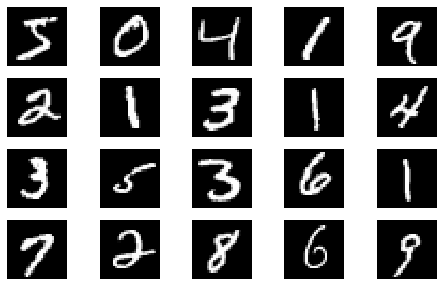

In [4]:
plt.figure(figsize=(8, 5))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy(),'gray')
    plt.axis('off');

## 2. 创建网络
 
定义网络时，需要继承nn.Module，并实现它的forward方法，把网络中具有可学习参数的层放在构造函数__init__中。

只要在nn.Module的子类中定义了forward函数，backward函数就会自动被实现(利用autograd)。

In [0]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        # nn.Module子类的函数必须在构造函数中执行父类的构造函数
        # 下式等价于nn.Module.__init__(self)        
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        # 这里直接用 Sequential 就定义了网络，注意要和下面 CNN 的代码区分开
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        # view一般出现在model类的forward函数中，用于改变输入或输出的形状
        # x.view(-1, self.input_size) 的意思是多维的数据展成二维
        # 代码指定二维数据的列数为 input_size=784，行数 -1 表示我们不想算，电脑会自己计算对应的数字
        # 在 DataLoader 部分，我们可以看到 batch_size 是64，所以得到 x 的行数是64
        # 大家可以加一行代码：print(x.cpu().numpy().shape)
        # 训练过程中，就会看到 (64, 784) 的输出，和我们的预期是一致的

        # forward 函数的作用是，指定网络的运行过程，这个全连接网络可能看不啥意义，
        # 下面的CNN网络可以看出 forward 的作用。
        x = x.view(-1, self.input_size)
        return self.network(x)
    


class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        # 执行父类的构造函数，所有的网络都要这么写
        super(CNN, self).__init__()
        # 下面是网络里典型结构的一些定义，一般就是卷积和全连接
        # 池化、ReLU一类的不用在这里定义
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)    
    
    # 下面的 forward 函数，定义了网络的结构，按照一定顺序，把上面构建的一些结构组织起来
    # 意思就是，conv1, conv2 等等的，可以多次重用
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

定义训练和测试函数

In [0]:
# 训练函数
def train(model):
    model.train()
    # 主里从train_loader里，64个样本一个batch为单位提取样本进行训练
    for batch_idx, (data, target) in enumerate(train_loader):
        # 把数据送到GPU中
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # 把数据送到GPU中
        data, target = data.to(device), target.to(device)
        # 把数据送入模型，得到预测结果
        output = model(data)
        # 计算本次batch的损失，并加到 test_loss 中
        test_loss += F.nll_loss(output, target, reduction='sum').item()
        # get the index of the max log-probability，最后一层输出10个数，
        # 值最大的那个即对应着分类结果，然后把分类结果保存在 pred 里
        pred = output.data.max(1, keepdim=True)[1]
        # 将 pred 与 target 相比，得到正确预测结果的数量，并加到 correct 中
        # 这里需要注意一下 view_as ，意思是把 target 变成维度和 pred 一样的意思                                                
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

## 3. 在小型全连接网络上训练（Fully-connected network）

In [16]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

train(model_fnn)
test(model_fnn)

Number of parameters: 6442
Train: [0/60000 (0%)]	Loss: 2.302146
Train: [6400/60000 (11%)]	Loss: 1.951977
Train: [12800/60000 (21%)]	Loss: 1.290410
Train: [19200/60000 (32%)]	Loss: 1.000708
Train: [25600/60000 (43%)]	Loss: 0.829704
Train: [32000/60000 (53%)]	Loss: 0.553799
Train: [38400/60000 (64%)]	Loss: 0.596026
Train: [44800/60000 (75%)]	Loss: 0.720949
Train: [51200/60000 (85%)]	Loss: 0.557444
Train: [57600/60000 (96%)]	Loss: 0.593830

Test set: Average loss: 0.4253, Accuracy: 8735/10000 (87%)



## 3. 在卷积神经网络上训练

需要注意的是，上在定义的CNN和全连接网络，拥有相同数量的模型参数

In [18]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

train(model_cnn)
test(model_cnn)

Number of parameters: 6422
Train: [0/60000 (0%)]	Loss: 2.328946
Train: [6400/60000 (11%)]	Loss: 1.301481
Train: [12800/60000 (21%)]	Loss: 0.472606
Train: [19200/60000 (32%)]	Loss: 0.415483
Train: [25600/60000 (43%)]	Loss: 0.179762
Train: [32000/60000 (53%)]	Loss: 0.350131
Train: [38400/60000 (64%)]	Loss: 0.177829
Train: [44800/60000 (75%)]	Loss: 0.121229
Train: [51200/60000 (85%)]	Loss: 0.140334
Train: [57600/60000 (96%)]	Loss: 0.333439

Test set: Average loss: 0.1266, Accuracy: 9615/10000 (96%)



通过上面的测试结果，可以发现，含有相同参数的 CNN 效果要明显优于 简单的全连接网络，是因为 CNN 能够更好的挖掘图像中的信息，主要通过两个手段：
- 卷积：Locality and stationarity in images
- 池化：Builds in some translation invariance

## 5. 打乱像素顺序再次在两个网络上训练与测试

考虑到CNN在卷积与池化上的优良特性，如果我们把图像中的像素打乱顺序，这样 卷积 和 池化 就难以发挥作用了，为了验证这个想法，我们把图像中的像素打乱顺序再试试。

首先下面代码展示随机打乱像素顺序后，图像的形态：

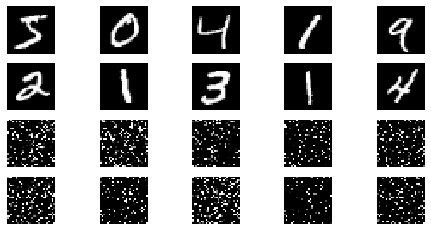

In [20]:
# 这里解释一下 torch.randperm 函数，给定参数n，返回一个从0到n-1的随机整数排列
perm = torch.randperm(784)
plt.figure(figsize=(8, 4))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy(), 'gray')
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy(), 'gray')
    plt.axis('off')

重新定义训练与测试函数，我们写了两个函数 train_perm 和 test_perm，分别对应着加入像素打乱顺序的训练函数与测试函数。

与之前的训练与测试函数基本上完全相同，只是对 data 加入了打乱顺序操作。

In [0]:
# 对每个 batch 里的数据，打乱像素顺序的函数
def perm_pixel(data, perm):
    # 转化为二维矩阵
    data_new = data.view(-1, 28*28)
    # 打乱像素顺序
    data_new = data_new[:, perm]
    # 恢复为原来4维的 tensor
    data_new = data_new.view(-1, 1, 28, 28)
    return data_new

# 训练函数
def train_perm(model, perm):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # 像素打乱顺序
        data = perm_pixel(data, perm)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# 测试函数
def test_perm(model, perm):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # 像素打乱顺序
        data = perm_pixel(data, perm)

        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()
        pred = output.data.max(1, keepdim=True)[1]                                            
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

在全连接网络上训练与测试：

In [13]:
perm = torch.randperm(784)
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

train_perm(model_fnn, perm)
test_perm(model_fnn, perm)

Number of parameters: 6442
Train: [0/60000 (0%)]	Loss: 2.264858
Train: [6400/60000 (11%)]	Loss: 2.041490
Train: [12800/60000 (21%)]	Loss: 1.552290
Train: [19200/60000 (32%)]	Loss: 1.093537
Train: [25600/60000 (43%)]	Loss: 0.799383
Train: [32000/60000 (53%)]	Loss: 0.847221
Train: [38400/60000 (64%)]	Loss: 0.756004
Train: [44800/60000 (75%)]	Loss: 0.723714
Train: [51200/60000 (85%)]	Loss: 0.438829
Train: [57600/60000 (96%)]	Loss: 0.474032

Test set: Average loss: 0.5751, Accuracy: 8348/10000 (83%)



在卷积神经网络上训练与测试：

In [14]:
perm = torch.randperm(784)
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

train_perm(model_cnn, perm)
test_perm(model_cnn, perm)

Number of parameters: 6422
Train: [0/60000 (0%)]	Loss: 2.300903
Train: [6400/60000 (11%)]	Loss: 2.282535
Train: [12800/60000 (21%)]	Loss: 2.261807
Train: [19200/60000 (32%)]	Loss: 2.111837
Train: [25600/60000 (43%)]	Loss: 1.717916
Train: [32000/60000 (53%)]	Loss: 1.320999
Train: [38400/60000 (64%)]	Loss: 0.960259
Train: [44800/60000 (75%)]	Loss: 0.961738
Train: [51200/60000 (85%)]	Loss: 0.636504
Train: [57600/60000 (96%)]	Loss: 0.507474

Test set: Average loss: 0.6227, Accuracy: 8003/10000 (80%)



从打乱像素顺序的实验结果来看，全连接网络的性能基本上没有发生变化，但是 卷积神经网络的性能明显下降。

这是因为对于卷积神经网络，会利用像素的局部关系，但是打乱顺序以后，这些像素间的关系将无法得到利用。